# Using Neural network for volatility model calibration 

The study consists in volatility model calibration (under risk-neutral) using deep learning methods (Feed forward and CNN architecture). We test both from observed prices and from IV surface. Synthetic data are generated for training using Fourier pricing and root-finding

#### [References]
- Fang, F., & Oosterlee, C. W. (2009). A Novel Pricing Method for European Options Based on Fourier-Cosine Series Expansions. SIAM Journal on Scientific Computing, 31(2), 826. doi:10.1137/080718061
- Horvath, B., Muguruza, A. and Tomas, M., 2019. Deep Learning Volatility, A deep neural network perspective on pricing and calibration in (rough) volatility models
- https://github.com/khrapovs/fangoosterlee
-  https://github.com/amuguruza/NN-StochVol-Calibrations/blob/master/Heston/NNHeston.ipynb

In [1]:
import numpy as np
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.random import standard_normal, seed, uniform, randint
import scipy.stats as stats
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
from models import MLPRegressor, CNNRegressor
from hyperparam_opt import bayesian_tuning, BayesianSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold 
from sklearn.metrics import mean_squared_error
from hyperopt import hp, tpe, Trials

Using TensorFlow backend.


## 0. The Heston model

Recall that the Heston Model is defined as follow (under risk-neutral measure):
$$dS_t=r S_tdt+ \sqrt{v_t} S_tdW^S_t$$
$$dv_t=\kappa (v - v_t)dt+\gamma \sqrt{v_t}dW^v_t$$

$d \langle W^S, W^v\rangle_t = \rho_{Sv}dt\quad$, $\quad S_{t_0}=S_0$, $\quad v_{t_0}=v_0$

Pricing under the Heston model could be done in several ways. In this project, we use the implementation of COS method from Fang, F., Oosterlee (2009).  

## 1. IV surface generation for Heston with MLP vs root-finding

In this section, an MLP is trained to map the input Heston parameters $(\kappa,v, v_0, \gamma, \rho)$ directly to the Heston IV surface. Results are compared to the COS pricer + Root finding

### Data generation using random uniform

In [15]:
from fangoosterlee import Heston, HestonParam, cosmethod
from impvol import (imp_vol, impvol_bisection, lfmoneyness, blackscholes_norm,
                    impvol_table)

def cos_heston_price(S_0, K, r, T, v, v_0, kappa, gamma, rho, call=True):

    moneyness = np.log(K / S_0) - r * T
    param = HestonParam(lm=kappa, mu=v, eta=gamma, rho=rho, sigma=v_0)
    model = Heston(param, r, T)
    P = cosmethod(model, moneyness=moneyness, call=call)
    return P[0]

def iv_surface_root_finding(s_0, premium, K_range, T, r, call, method='root'):
    moneyness = lfmoneyness(s_0, K_range, r, T)
    premium = premium / S_0
    if method == 'root':
        vol = imp_vol(moneyness, T, premium, call)
    else:
        vol = impvol_bisection(moneyness, T, premium, call)
    return vol

n_sample = 1000
init_var = uniform(low=0.05, high=1, size=n_sample)
mean_variance = uniform(low=0.01, high=1, size=n_sample)
reversion_speed = uniform(low=0.01, high=3, size=n_sample)
gamma = uniform(low=0.01, high=0.8, size=n_sample)
rho = uniform(low=-0.9, high=0, size=n_sample)

S_0 = 1
r = 0.02
K_range=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5])
T_range=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

## Data generation
y_data = np.zeros((n_sample, len(K_range)*len(T_range)))
x_data = np.vstack((init_var, mean_variance, reversion_speed, gamma, rho)).T

starttime = time.time()
for i in range(n_sample):
    heston_premium = np.array([[cos_heston_price(S_0, K_range[k], r, T_range[j],
                                                 mean_variance[i],
                                                 init_var[i],
                                                 reversion_speed[i],
                                                 gamma[i],
                                                 rho[i],
                                                 call=True)
                              for j in range(len(T_range))]
                             for k in range(len(K_range))])
    iv_surface = [iv_surface_root_finding(S_0, heston_premium[:, i], K_range,
                                          T_range[i], r, call=np.ones(len(K_range), dtype=bool))
                  for i in range(len(T_range))]
    
    y_data[i,:] = np.hstack(iv_surface)
endtime = time.time()
print('\nTime Cost generation:', endtime - starttime, 'seconds')

y_data = np.where(y_data>1.5, 0.5, y_data) # deal with outliers
y_data = np.where(y_data<-5, 0.5, y_data)


Time Cost generation: 837.5905771255493 seconds


#### Use of data from https://github.com/amuguruza/NN-StochVol-Calibrations/blob/master/Heston/NNHeston.ipynb

In [7]:
import gzip
f = gzip.GzipFile('data/HestonTrainSet.txt.gz', "r")
data=np.load(f)

xx=data[:,:5]
yy=data[:,5:]
X_train, X_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.15, random_state=42)

K_range=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
T_range=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

In [8]:
params = ["v_0","rho","gamma","v", "kappa"]
for j in range(5):
    print('param: ', params[j], '      min: ', np.min(xx[:,j]), '    max: ', np.max(xx[:,j]))


param:  v_0       min:  0.00010051277450683825     max:  0.039991680569173786
param:  rho       min:  -0.9497629357529248     max:  -0.10001060294834896
param:  gamma       min:  0.010013913703347196     max:  0.9999707585067652
param:  v       min:  0.013285952700406892     max:  0.1999997937325088
param:  kappa       min:  1.0177017387052407     max:  9.999740678893833


### Train the MLP network

In [9]:
model = MLPRegressor(
    scaler=StandardScaler(),
    epochs=150,
    batch_size=32,
    hidden_size=50,
    hidden_size_2=50,
    dropout=0.,
    learning_rate=0.001,
    loss="mse",
    activation='elu',
    verbose=1
)

model.fit(X_train, y_train, validation_split=0.2)

Epoch 1/150
255/255 [==============================] - 1s 3ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 2/150
255/255 [==============================] - 0s 2ms/step - loss: 9.3512e-04 - mse: 9.3512e-04 - val_loss: 5.5889e-04 - val_mse: 5.5889e-04
Epoch 3/150
255/255 [==============================] - 0s 2ms/step - loss: 3.8663e-04 - mse: 3.8663e-04 - val_loss: 2.7350e-04 - val_mse: 2.7350e-04
Epoch 4/150
255/255 [==============================] - 0s 2ms/step - loss: 2.1161e-04 - mse: 2.1161e-04 - val_loss: 1.7103e-04 - val_mse: 1.7103e-04
Epoch 5/150
255/255 [==============================] - 1s 3ms/step - loss: 1.4231e-04 - mse: 1.4231e-04 - val_loss: 1.2719e-04 - val_mse: 1.2719e-04
Epoch 6/150
255/255 [==============================] - 1s 2ms/step - loss: 1.0516e-04 - mse: 1.0516e-04 - val_loss: 9.2923e-05 - val_mse: 9.2923e-05
Epoch 7/150
255/255 [==============================] - 1s 2ms/step - loss: 8.1622e-05 - mse: 8.1622e-05 - val_loss: 7.5335

255/255 [==============================] - 1s 2ms/step - loss: 3.5180e-06 - mse: 3.5180e-06 - val_loss: 3.7442e-06 - val_mse: 3.7442e-06
Epoch 110/150
255/255 [==============================] - 1s 2ms/step - loss: 3.1607e-06 - mse: 3.1607e-06 - val_loss: 3.8854e-06 - val_mse: 3.8854e-06
Epoch 111/150
255/255 [==============================] - 0s 2ms/step - loss: 3.2717e-06 - mse: 3.2717e-06 - val_loss: 4.6511e-06 - val_mse: 4.6511e-06
Epoch 112/150
255/255 [==============================] - 1s 2ms/step - loss: 3.2015e-06 - mse: 3.2015e-06 - val_loss: 4.3619e-06 - val_mse: 4.3619e-06
Epoch 113/150
255/255 [==============================] - 1s 3ms/step - loss: 3.2059e-06 - mse: 3.2059e-06 - val_loss: 3.1656e-06 - val_mse: 3.1656e-06
Epoch 114/150
255/255 [==============================] - 0s 2ms/step - loss: 3.2559e-06 - mse: 3.2559e-06 - val_loss: 3.1003e-06 - val_mse: 3.1003e-06
Epoch 115/150
255/255 [==============================] - 0s 2ms/step - loss: 3.3437e-06 - mse: 3.3437e-06 - 

MLPRegressor(epochs=150, loss='mse', verbose=1)

In [13]:
## train test error
model.verbose = 0
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
print('mse on train set', mean_squared_error(y_train, pred_train))
print('mse on test set', mean_squared_error(y_test, pred_test))
print('mae on train set', mean_absolute_error(y_train, pred_train))
print('mae on test set', mean_absolute_error(y_test, pred_test))

mse on train set 2.475661265423967e-06
mse on test set 2.533233643047933e-06
mae on train set 0.000928258791248034
mae on test set 0.0009461363833455284


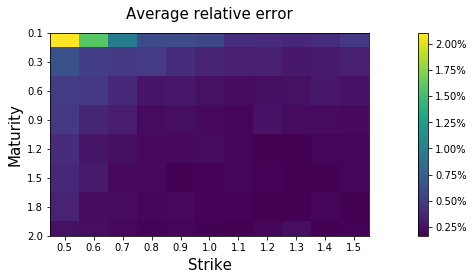

In [14]:
import matplotlib.ticker as mtick

plt.figure(figsize=(14,4))
ax=plt.subplot(1,1,1)
err = np.mean(100*np.abs((y_test-pred_test)/y_test),axis = 0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(len(T_range),len(K_range)))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(K_range)-1,len(K_range)))
ax.set_xticklabels(K_range)
ax.set_yticks(np.linspace(0,len(T_range)-1,len(T_range)))
ax.set_yticklabels(T_range)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.tight_layout()

### Optimize hyperparameters


In [ ]:
param_grid = {
    'epochs': hp.choice('epochs', [100, 120, 150, 200, 220, 250]),
    'batch_size': hp.choice('batch_size', [32, 64, 128]),
    'learning_rate': hp.loguniform('learning_rate',np.log(0.0001), np.log(0.01)),
    'hidden_size': hp.choice('hidden_size',[int(x) for x in np.linspace(50, 200, 10)]),
    'hidden_size_2': hp.choice('hidden_size_2',[int(x) for x in np.linspace(50, 200, 10)]),
    'dropout':  hp.uniform('dropout', 0., 0.1),
}

model = MLPRegressor(
    scaler=StandardScaler(),
    loss="mse",
    activation='elu',
    verbose=0
)
cv_gen = KFold(n_splits=3)

estimator = BayesianSearchCV(estimator=model, param_distributions=param_grid,
                             scoring=mean_squared_error, cv=cv_gen, refit=True,
                             optimizer=tpe.suggest, n_iter=20,
                             random_state=np.random.seed(42), n_jobs=1)

estimator.fit(X_train, y_train)

In [5]:
print(estimator.trials_[0]['hyperparameters'])

{'batch_size': 32, 'dropout': 0.005689253827716634, 'epochs': 200, 'hidden_size': 120, 'hidden_size_2': 95, 'learning_rate': 0.001979859507724926}


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 120)               720       
_________________________________________________________________
dropout (Dropout)            (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               14520     
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 95)                11495     
_________________________________________________________________
dropout_2 (Dropout)          (None, 95)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 88)                8

In [15]:
estimator.estimator.save('KerasHestonVol')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: KerasHestonVol\assets


INFO:tensorflow:Assets written to: KerasHestonVol\assets


### Overall error

In [17]:
## train test error
pred_train = model.predict(X_train)
starttime = time.time()
pred_test = model.predict(X_test)
endtime = time.time()
print(f'\nTime Cost testing on {X_test.shape[0]} samples:', endtime - starttime, 'seconds')
print('mse on train set', mean_squared_error(y_train, pred_train))
print('mse on test set', mean_squared_error(y_test, pred_test))
print('mae on train set', mean_absolute_error(y_train, pred_train))
print('mae on test set', mean_absolute_error(y_test, pred_test))


Time Cost testing on 1800 samples: 0.05186104774475098 seconds
mse on train set 3.6469494469630716e-06
mse on test set 3.663651036813827e-06
mae on train set 0.0012674241018830218
mae on test set 0.0012631906746761333


### Error on the whole surface

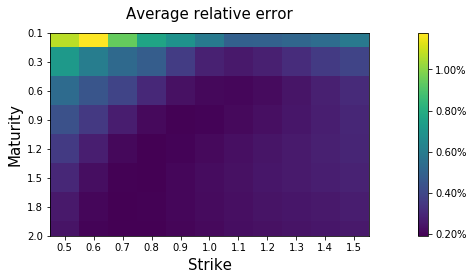

In [179]:
import matplotlib.ticker as mtick

plt.figure(figsize=(14,4))
ax=plt.subplot(1,1,1)
err = np.mean(100*np.abs((y_test-pred_test)/y_test),axis = 0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(len(T_range),len(K_range)))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(K_range)-1,len(K_range)))
ax.set_xticklabels(K_range)
ax.set_yticks(np.linspace(0,len(T_range)-1,len(T_range)))
ax.set_yticklabels(T_range)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.tight_layout()

### Example

[ 0.00620736 -0.629199    0.138246    0.10907079  6.10634058]


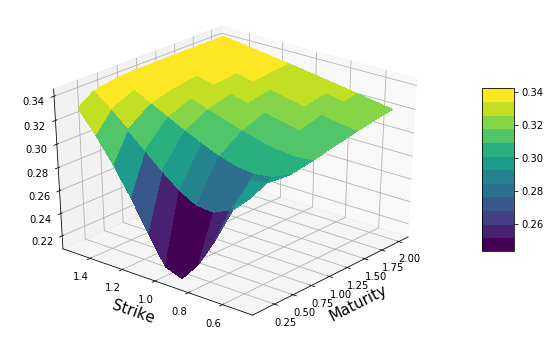

In [222]:
i = np.random.choice(range(10200, 12000, 1))
sample = xx[i,:]
print(sample)
sample = np.array( [0.01799103, -0.29271735,  0.89585693,  0.12036402,  7.8141966 ]).reshape(1,-1)
pred_sample = estimator.predict(sample.reshape(1,-1))
pred_iv = pred_sample.reshape(len(T_range), len(K_range))

X, Y = np.meshgrid(np.array(T_range), np.array(K_range))
Z = np.array(pred_iv).T
fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.get_cmap('viridis', 12),
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(elev=30, azim=220)
plt.xlabel("Maturity",fontsize=15,labelpad=5)
plt.ylabel("Strike",fontsize=15,labelpad=5)
plt.show()



## 2. Heston parameters calibration with ANN

### 2.1. Calibration from Implied volatility using previously trained NN

In [ ]:
from keras import backend as K
from tensorflow import keras
import tensorflow as tf
tf.compat.v1.disable_eager_execution()


def transform(x):
    return (x - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
    
def inverse_transform(x):
    return x *  np.std(X_train, axis=0) + np.mean(X_train, axis=0)
    
model = keras.models.load_model('KerasHestonVol')

MLP = K.function([model.layers[0].input, K.learning_phase()],
                           [model.layers[-1].output])
learning_phase = False 

output_tensor = model.layers[-1].output
variable_tensors_list = model.trainable_weights
gradients = K.gradients(output_tensor, variable_tensors_list)
#gradients = [grad.experimental_ref() for grad in gradients]

# sess = tf.compat.v1.InteractiveSession()
# sess.run(tf.compat.v1.global_variables_initializer())
sess = tf.compat.v1.keras.backend.get_session() 


def objective(x, idx):  
    return np.sum(np.power((MLP([transform(x).reshape(1, -1), learning_phase])[0] - y_test[idx]), 2))
    
def jacobian(x, idx): 
    grads = sess.run(gradients, feed_dict={model.input:transform(x).reshape(1, -1)})[-1] # gradient at last layer
    return 2*np.sum((MLP([transform(x).reshape(1, -1), learning_phase])[0] - y_test[idx]) * grads, axis=1)
    

def jacobian_tf(x, idx):    
    jacobian_matrix = []
    for i in range(88):
        grad_func = tf.gradients(model.output[:, i], model.input)
        gradients = sess.run(grad_func, feed_dict={model.input: transform(x).reshape((1, -1))})
        jacobian_matrix.append(gradients[0][0,:])
    
    jacobian_matrix = np.array(jacobian_matrix)
    obj_grad = 2 * np.sum((MLP([transform(x).reshape(1, -1), learning_phase])[0] - y_test[1]).T * jacobian_matrix, axis=0)
    return obj_grad

In [11]:
from scipy.optimize import minimize, differential_evolution, dual_annealing
from scipy.optimize import Bounds

f = gzip.GzipFile('data/HestonTrainSet.txt.gz', "r")
data=np.load(f)

xx=data[:,:5]
yy=data[:,5:]
X_train, X_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.15, random_state=42)


init_guess = np.array([0.01, -0.5, 0.02, 0.02, 2])

bounds = ((0., 0.04), (-1, -0.1), (0.01, 1.), (0.01, 0.2), (1., 10))

res_minimize, res_de, res_da = list(), list(), list()
seeds = [1, 5, 10, 15]

# transform with training data

starttime = time.time()
for i in range(X_test.shape[0]):
    res=minimize(objective,
                 x0=init_guess, args=(i,),
                 method='L-BFGS-B',
                 bounds=bounds,
                 # jac=jacobian_tf,  
                 tol=1e-10,
                 options={"maxiter":5000})
    res_minimize.append(res.x)
    
endtime = time.time()
print(f'\nTime Cost L-BFGS-B on {X_test.shape[0]} samples:', endtime - starttime, 'seconds')
    
    
    
starttime = time.time()
for i in range(100):
    list_tmp_de = list()
    for seed in seeds:
        res=differential_evolution(objective,
                                   bounds=bounds,
                                   args=(i,),
                                   seed=seed, 
                                   maxiter=1000)
        list_tmp_de.append(res.x)
    res_de.append(list_tmp_de)
endtime = time.time()
print(f'\nTime Cost DE on {X_test.shape[0]} samples and {len(seeds)} seeds:', endtime - starttime, 'seconds')


Time Cost L-BFGS-B on 1800 samples: 118.20951795578003 seconds
Time Cost DE on 100 samples and 4 seeds: 2828.086258172989 seconds


In [14]:
res_de = np.array(res_de)
res_da = np.array(res_da)
params_names = ["v_0","rho","gamma","v", "kappa"]

print('________________  Differential evolution  _______________')
for j in range(5):
    print(f'{params_names[j]} relative error - mean abs error:   ',
          np.mean([np.mean(100 * np.abs((X_test[:100,j] - res_de[:,i,j])/X_test[:100,j])) for i in range(4)]), '   ',
          np.mean([np.mean(np.abs(X_test[:100,j] - res_de[:,i,j])) for i in range(4)]))


________________  Differential evolution  __________________

v_0 relative error - mean abs error:    28.958647478782396     0.0009130156193556637
rho relative error - mean abs error:    7.80386846100475     0.029848476910892204
gamma relative error - mean abs error:    4.812096940997358     0.01554099122402948
v relative error - mean abs error:    0.8082882985013917     0.0008864441654949993
kappa relative error - mean abs error:    2.3264929843396613     0.14722801571136213


### 2. Train MLP to map IV surface to Heston params set

In [4]:
import gzip
f = gzip.GzipFile('data/HestonTrainSet.txt.gz', "r")
data=np.load(f)

yy=data[:,:5]
xx=data[:,5:]
X_train, X_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.15, random_state=42)

K_range=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
T_range=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

model = MLPRegressor(
    scaler=MinMaxScaler(),
    output_scaler=MinMaxScaler(),
    hidden_size=100,
    epochs=150,
    batch_size=64,
    loss="mse",
    activation='elu',
    learning_rate=0.0005,
    verbose=1
)
model.fit(X_train, y_train, validation_split=0.2)

Epoch 1/150
128/128 [==============================] - 1s 5ms/step - loss: 0.0414 - mse: 0.0414 - val_loss: 0.0236 - val_mse: 0.0236
Epoch 2/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0201 - mse: 0.0201 - val_loss: 0.0170 - val_mse: 0.0170
Epoch 3/150
128/128 [==============================] - 1s 4ms/step - loss: 0.0154 - mse: 0.0154 - val_loss: 0.0134 - val_mse: 0.0134
Epoch 4/150
128/128 [==============================] - 0s 4ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 5/150
128/128 [==============================] - 0s 4ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 6/150
128/128 [==============================] - 1s 6ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 7/150
128/128 [==============================] - 0s 4ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 8/150
128/128 [==============================] - 1s 4ms/step - 

128/128 [==============================] - 0s 3ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 124/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 125/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 126/150
128/128 [==============================] - 0s 4ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 127/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 128/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 129/150
128/128 [==============================] - 0s 3ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 130/150
128/128 [==============================] - 0s 3ms/step 

MLPRegressor(batch_size=64, epochs=150, loss='mse',
             output_scaler=MinMaxScaler(), scaler=MinMaxScaler(), verbose=1)

In [5]:
## train test error, output is unscaled inside the predict method
pred_train = model.predict(X_train)
starttime = time.time()
pred_test = model.predict(X_test)
endtime = time.time()
print(f'\nTime Cost testing on {X_test.shape[0]} samples:', endtime - starttime, 'seconds')
print('mse on train set', mean_squared_error(y_train, pred_train))
print('mse on test set', mean_squared_error(y_test, pred_test))
print('mae on train set', mean_absolute_error(y_train, pred_train))
print('mae on test set', mean_absolute_error(y_test, pred_test))


Time Cost testing on 1800 samples: 0.16655492782592773 seconds
mse on train set 0.0054588414582017585
mse on test set 0.006294724513993405
mae on train set 0.03033114162997668
mae on test set 0.030527813739260685


In [7]:
error = pd.DataFrame(mean_absolute_error(y_test, pred_test, multioutput = 'raw_values')).T
error_perc = np.mean(np.divide(np.abs(y_test - pred_test), y_test)*100, axis=0)
error_perc = pd.DataFrame(error_perc).T
error = pd.concat([error, error_perc], axis=0)
error.rename(columns={0:'v_0', 1:'rho', 2:'gamma', 3:'v', 4:'kappa'}, inplace=True)
error.set_index(np.array(['mae', 'mae%']), inplace=True)
print('abs error for each parameters:')
error

abs error for each parameters:


,v_0,rho,gamma,v,kappa
mae,0.000722,0.036877,0.012727,0.001144,0.101170
mae%,22.233963,-12.536887,9.468360,0.996632,1.819504


### 3. Train CNN regressor to map IV surface to Heston params set

In [3]:
import gzip
f = gzip.GzipFile('data/HestonTrainSet.txt.gz', "r")
data=np.load(f)

yy=data[:,:5]
xx=data[:,5:]
X_train, X_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.15, random_state=42)

K_range=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
T_range=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])


In [4]:
from ml_utils_ts.models import CNNRegressor
from ml_utils_ts.calibration import bayesian_tuning
from tensorflow.keras.optimizers import Adadelta, Adam
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
from sklearn.preprocessing import MinMaxScaler

scaler_in, scaler_out = MinMaxScaler(), MinMaxScaler()
X_train = scaler_in.fit_transform(X_train)
X_test = scaler_in.transform(X_test)
y_train = scaler_out.fit_transform(y_train)

X_train = X_train.reshape(X_train.shape[0], len(T_range),len(K_range), 1)
X_test = X_test.reshape(X_test.shape[0], len(T_range),len(K_range), 1)

initial_learning_rate = 1.
decay_steps = 1.0
decay_rate = 0.5
learning_rate_fn = InverseTimeDecay(initial_learning_rate, decay_steps, decay_rate)
optimizer = Adam(lr=0.0005)

# use Adadelta optimizer by default
model = CNNRegressor(
    input_shape=(8,11,1),
    kernel_size=(2,2),
    hidden_size=200,
    filters=32,
    activation='elu',
    n_output=5,
    epochs=150,
    batch_size=64,
    loss="mse",
    optimizer=optimizer,
    verbose=1
)
model.model.summary()
model.fit(X_train, y_train, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 7, 10, 32)         160       
_________________________________________________________________
flatten (Flatten)            (None, 2240)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               448200    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1000      
Total params: 449,360
Trainable params: 449,360
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
128/128 [==============================] - 1s 12ms/step - loss: 0.0585 - val_loss: 0.0181
Epoch 2/150
128/128 [==============================] - 2s 12ms/step - loss: 0.0147 - val_loss: 0.0107
Epoch 3/150
128/128 [=======================

CNNRegressor(batch_size=64, epochs=150, input_shape=(8, 11, 1), loss='mse',
             n_output=5, verbose=1)

In [5]:
## train test error
pred_train = model.predict(X_train)
pred_train = scaler_out.inverse_transform(pred_train)
starttime = time.time()
pred_test = model.predict(X_test)
pred_test = scaler_out.inverse_transform(pred_test)
endtime = time.time()
y_train = scaler_out.inverse_transform(y_train)
print(f'\nTime Cost testing on {X_test.shape[0]} samples:', endtime - starttime, 'seconds')
print('mse on train set', mean_squared_error(y_train, pred_train))
print('mse on test set', mean_squared_error(y_test, pred_test))
print('mae on train set', mean_absolute_error(y_train, pred_train))
print('mae on test set', mean_absolute_error(y_test, pred_test))


Time Cost testing on 1800 samples: 0.24235105514526367 seconds
mse on train set 0.00827139772930397
mse on test set 0.012218009869597084
mae on train set 0.03256371997559916
mae on test set 0.03310960244971818


In [6]:
error = pd.DataFrame(mean_absolute_error(y_test, pred_test, multioutput = 'raw_values')).T
error_perc = np.mean(np.divide(np.abs(y_test - pred_test), y_test)*100, axis=0)
error_perc = pd.DataFrame(error_perc).T
error = pd.concat([error, error_perc], axis=0)
error.rename(columns={0:'v_0', 1:'rho', 2:'gamma', 3:'v', 4:'kappa'}, inplace=True)
error.set_index(np.array(['mae', 'mae%']), inplace=True)
print('abs error for each parameters:')
error

abs error for each parameters:


,v_0,rho,gamma,v,kappa
mae,0.000275,0.039494,0.010855,0.001538,0.113385
mae%,9.768914,-12.691896,7.094958,1.303206,2.381544


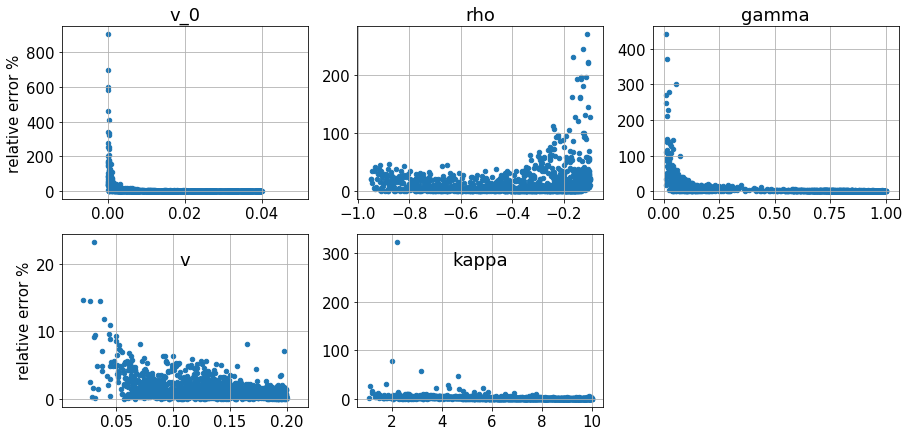

In [34]:
diff = y_test - pred_test
fig=plt.figure(figsize=(15,7))
names = {0:'v_0', 1:'rho', 2:'gamma', 3:'v', 4:'kappa'}
for i in range(5):
    ax=plt.subplot(2,3,i+1)
    plt.scatter(y_test[:,i], 100*np.abs(pred_test[:,i]-y_test[:,i])/np.abs(y_test[:,i]), s=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    if i in [0, 3]:
        plt.ylabel('relative error %', fontsize=15)
    plt.title(names[i], fontsize=18)
    if i in [3,4]:
        ax.set_title(names[i], y=0.99, pad=-30, fontsize=18)
    plt.grid()

### 4. Calibration from prices

Train a NN to find the Heston paramters that "reflect" the observable liquid option price on market.
Fixing some value such as $K$, $T$ and $r$, and given a range of observed option prices for different init stock price ($S_0$) and init variance ($v_0$) as explanatory variables, the ANN learns to predict $(\kappa,v,\gamma, \rho)$ 
Then Test using observed prices of different $T$ and $K$ for a given init price $S_0$ and init $v_0$

### Generate data from uniform sampling

In [7]:
from pricing_utils import cos_heston_price

#fix some parameters
K = 100
T = 1
r = 0.02

n_sample = 10000

x_data = np.zeros((n_sample, 10, 10)) # grid of 10x10 different prices
y_data = np.zeros((n_sample, 4))

#first define a space of S_0, v_0 values in which we will sample 10x10 values
init_price = 100 * uniform(low=0.4, high=1.6, size=15)
init_var = uniform(low=0.05, high=1, size=15)

mean_variance = uniform(low=0.01, high=1, size=n_sample)
reversion_speed = uniform(low=0.01, high=3, size=n_sample)
gamma = uniform(low=0.01, high=0.8, size=n_sample)
rho = uniform(low=-0.9, high=0, size=n_sample)

for i in range(n_sample):
    S_0 = np.random.choice(init_price, replace=False, size=10)
    v_0 = np.random.choice(init_var, replace=False, size=10)
    y_data[i,:] = np.array([reversion_speed[i], mean_variance[i], gamma[i], rho[i]])
    x_data[i,::] = np.array([[cos_heston_price(S_0[j], K, r, T,
                                               mean_variance[i],
                                               v_0[k],
                                               reversion_speed[i],
                                               gamma[i],
                                               rho[i],
                                               call=True)
                              for j in range(S_0.shape[0])]
                             for k in range(v_0.shape[0])])
x_data = np.where(x_data>1, 1, x_data)
x_data = np.where(x_data<0, 0, x_data)

### CNN multi-Regression

In [8]:
from ml_utils_ts.models import CNNRegressor
from ml_utils_ts.calibration import bayesian_tuning
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train,  y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = X_train.reshape(X_train.shape[0], 10,10, 1)
X_test = X_test.reshape(X_test.shape[0], 10,10, 1)

param_grid = {
    'learning_rate': hp.loguniform('learning_rate',np.log(1.), np.log(100)),
    'activation': hp.choice('activation', ['relu', 'tanh']),
    'hidden_size': hp.choice('hidden_size',[int(x) for x in np.linspace(500, 1000, 20)]),

}
model = CNNRegressor(
    input_shape=(10,10,1),
    kernel_size=(2,2),
    n_output=5,
    epochs=200,
    batch_size=200,
    loss="mse",
    verbose=0
)
trials = Trials()

tuning_output = bayesian_tuning(
           X_train,
           y_train,
           model=model,
           param_grid=param_grid, 
           metric_fun=mean_squared_error,
           cv_gen=KFold(n_splits=5),
           nb_evals=30,       
           optimizer=tpe.suggest,
           trials=trials,
    )

best_params = tuning_output[0]['hyperparameters']
model.epochs = 100
print('hyperparameters used:')
print(best_params)
starttime = time.time()
model.fit(X_train, y_train)
endtime = time.time()
print('\nTime Cost training:', endtime - starttime, 'seconds')
y_hat = model.predict(X_train)
y_pred = model.predict(X_test)
print('mse on train set', mean_squared_error(y_train, y_hat))
print('mse on test set', mean_squared_error(y_test, y_pred))


100%|████████████████████████████████████████████████| 30/30 [02:57<00:00,  5.93s/trial, best loss: 0.1711858871057353]

hyperparameters used:
{'activation': 'relu', 'hidden_size': 894, 'learning_rate': 2.170582524678732}

Time Cost training: 12.529718399047852 seconds
mse on train set 0.2357965956244129
mse on test set 0.2359220904850561


### MLP multi-Regression (reference data)

In [4]:
import gzip
f = gzip.GzipFile('data/HestonTrainSet.txt.gz', "r")
data=np.load(f)

params = data[:,:5] 
S_0 = 1
r = 0.02

n_sample = params.shape[0]

K_range=np.array([ 0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,])
T_range=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

x_data, y_data = list(), list()
for i in range(n_sample):
    price_array = np.array([[cos_heston_price(1, K_range[j], r, T_range[k],
                                               params[i, 2],
                                               params[i, 0],
                                               params[i, 3],
                                               params[i, 1],
                                               params[i, 0],
                                               call=True)
                              for j in range(K_range.shape[0])]
                             for k in range(T_range.shape[0])])
    if np.any(price_array > 1) or np.any(price_array < 0):
        continue
        
    x_data.append(price_array)
    y_data.append(params[i])
    
x_data = np.array(x_data)
y_data = np.array(y_data)

In [7]:
X_train, X_test, y_train,  y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)
X_train = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(-1,X_test.shape[1] * X_test.shape[2])

model = MLPRegressor(
    scaler=MinMaxScaler(),
    output_scaler=MinMaxScaler(),
    hidden_size=100,
    hidden_size_2=50,
    learning_rate=0.0005,
    epochs=300,
    batch_size=32,
    loss="mse",
    activation='relu',
    verbose=1
)

model.fit(X_train, y_train, validation_split=0.2)

Epoch 1/300
134/134 [==============================] - 0s 3ms/step - loss: 0.0528 - mse: 0.0528 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 2/300
134/134 [==============================] - 0s 3ms/step - loss: 0.0281 - mse: 0.0281 - val_loss: 0.0274 - val_mse: 0.0274
Epoch 3/300
134/134 [==============================] - 0s 2ms/step - loss: 0.0251 - mse: 0.0251 - val_loss: 0.0245 - val_mse: 0.0245
Epoch 4/300
134/134 [==============================] - 0s 3ms/step - loss: 0.0237 - mse: 0.0237 - val_loss: 0.0243 - val_mse: 0.0243
Epoch 5/300
134/134 [==============================] - 0s 3ms/step - loss: 0.0228 - mse: 0.0228 - val_loss: 0.0239 - val_mse: 0.0239
Epoch 6/300
134/134 [==============================] - 0s 3ms/step - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0223 - val_mse: 0.0223
Epoch 7/300
134/134 [==============================] - 0s 3ms/step - loss: 0.0214 - mse: 0.0214 - val_loss: 0.0218 - val_mse: 0.0218
Epoch 8/300
134/134 [==============================] - 0s 3ms/step - 

134/134 [==============================] - 0s 2ms/step - loss: 0.0166 - mse: 0.0166 - val_loss: 0.0183 - val_mse: 0.0183
Epoch 124/300
134/134 [==============================] - 0s 2ms/step - loss: 0.0165 - mse: 0.0165 - val_loss: 0.0184 - val_mse: 0.0184
Epoch 125/300
134/134 [==============================] - 0s 2ms/step - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0181 - val_mse: 0.0181
Epoch 126/300
134/134 [==============================] - 0s 2ms/step - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 127/300
134/134 [==============================] - 0s 3ms/step - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0180 - val_mse: 0.0180
Epoch 128/300
134/134 [==============================] - 0s 3ms/step - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0179 - val_mse: 0.0179
Epoch 129/300
134/134 [==============================] - 0s 2ms/step - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0181 - val_mse: 0.0181
Epoch 130/300
134/134 [==============================] - 0s 2ms/step 

Epoch 184/300
134/134 [==============================] - 0s 3ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0181 - val_mse: 0.0181
Epoch 185/300
134/134 [==============================] - 1s 5ms/step - loss: 0.0161 - mse: 0.0161 - val_loss: 0.0179 - val_mse: 0.0179
Epoch 186/300
134/134 [==============================] - 0s 3ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0177 - val_mse: 0.0177
Epoch 187/300
134/134 [==============================] - 0s 3ms/step - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0176 - val_mse: 0.0176
Epoch 188/300
134/134 [==============================] - 0s 3ms/step - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0176 - val_mse: 0.0176
Epoch 189/300
134/134 [==============================] - 0s 3ms/step - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0176 - val_mse: 0.0176
Epoch 190/300
134/134 [==============================] - 0s 3ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0180 - val_mse: 0.0180
Epoch 191/300
134/134 [==============================] 

MLPRegressor(epochs=300, loss='mse', output_scaler=MinMaxScaler(),
             scaler=MinMaxScaler(), verbose=1)

In [8]:
y_hat = model.predict(X_train)
y_pred = model.predict(X_test)
print('mse on train set', mean_squared_error(y_train, y_hat))
print('mse on test set', mean_squared_error(y_test, y_pred))

mse on train set 0.9005536099148987
mse on test set 0.9746078234843057


In [9]:
error = pd.DataFrame(mean_absolute_error(y_test, y_pred, multioutput = 'raw_values')).T
error_perc = np.mean(np.divide(np.abs(y_test - y_pred), y_test)*100, axis=0)
error_perc = pd.DataFrame(error_perc).T
error = pd.concat([error, error_perc], axis=0)
error.rename(columns={0:'v_0', 1:'rho', 2:'gamma', 3:'v', 4:'kappa'}, inplace=True)
error.set_index(np.array(['mae', 'mae%']), inplace=True)
print('abs error for each parameters:')
error

abs error for each parameters:


,v_0,rho,gamma,v,kappa
mae,0.000328,0.020256,0.058421,0.016201,1.854474
mae%,8.157380,-8.617898,17.687702,12.719970,39.281881
